### **Rotation of 3D shape in a 2D projection**

**CANEILLES Charles, FOSSEY Oscar**

*ENSAE MS-DS, 2022*


The goal is to rotate a 3D shape around an axis. The application will be done with a function defining a cube with the axis that vertically crosses it in its center.

  - R0 reference of the space in which the curve will turn
  - RC space of the curve where the curve is centered in [0,0,0] 
  - Rpix space of the pixels on the 2D plane [u,v].

This report has 3 parts:

**1) Implementation of the program**

**2) Optimization with Cython and performance comparison**

**3) Results and conclusion**


### 1) Implementation of the program

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt

Lets define the useful values to construct our 3D space :

In [153]:
A = 3 # taille de l'espace : x E [0,A] et z E [0,A]
B = 10 # taille de l'espace : y E [0,B]

y_c = 7 #distance entre la caméra et le centre du cube y_c E [B/2,B]

L_pixels = 300 # nombre de pixel du plan 2D et de la fenetre

theta_c = 0 #angle de rotation de la courbe en degrès

e_c = 1 #epaisseur_cube

X_axe_R0 = np.array([[A/2],[y_c],[A/2]]) # Coordonnées du point dans R0 parlequel l'axe de rotation de la courbe 
                                         #  toujours verticale et centré
                                        
#on definie les intervalles de recherche dans R0 autour du centre du cube

Ix = [X_axe_R0[0][0]-e_c/np.sqrt(2), X_axe_R0[0][0]+e_c/np.sqrt(2)]
Iy = [X_axe_R0[1][0]-e_c/np.sqrt(2), X_axe_R0[1][0]+e_c/np.sqrt(2)]
Iz = [X_axe_R0[2][0]-e_c/np.sqrt(2), X_axe_R0[2][0]+e_c/np.sqrt(2)]
epsx = 0.03*e_c
epsy = 0.04*e_c

**Let's define the rotation matrix between the RC frame and R0**

In [6]:
def Rot(theta):
    "theta est en degrès ici"
    
    # remarque Rot(theta)**(-1) = Rot(-theta)
    
    return np.array([[-np.sin(theta*np.pi/180),-np.cos(theta*np.pi/180), 0],
                [np.cos(theta*np.pi/180), -np.sin(theta*np.pi/180), 0],
                [0,0,1]])

**Let us define the functions to switch from a space to an other, for our three spaces R0, RC and Rpix**

In [7]:
def from_R0_to_RC(X_R0):
    global X_axe_R0, e_c,theta_c
    return 1/e_c*Rot(-theta_c)@(X_R0-X_axe_R0)

def from_RC_to_R0(X_RC):
    global X_axe_R0, e_c
    return X_axe_R0 + e_c*Rot(theta_c)@X_RC

def from_R0_to_Rpix(X_R0):
    global X_axe_R0
    return [int(L_pixels*(0.5+B*(X_R0[0]-X_axe_R0[0])/(A*X_R0[1]))),
            int(L_pixels*(0.5+B*(X_R0[2]-X_axe_R0[2])/(A*X_R0[1])))]
    
def from_RC_to_Rpix(X, theta = theta_c):
    return from_R0_to_Rpix(from_RC_to_R0(X))

**Definition of our 3D shape**

In our case the cube is defined by abs(X) = [[0.5],[0.5],[0.5]], xith X in RC.

In [8]:
def g_du_cube_dans_RC(X):
    """return True si X est proche du cube à epsy près"""
    x = X[0][0]
    y = X[1][0]
    z = X[2][0]
    if abs(abs(x)-e_c/2) < epsy and abs(abs(y)-e_c/2) < epsy and abs(z) < e_c/2 + epsy:
        return True
    if abs(abs(z)-e_c/2) < epsy and abs(abs(x)-e_c/2) < epsy and abs(y) < e_c/2 + epsy:
        return True   
    if abs(abs(y)-e_c/2) < epsy and abs(abs(z)-e_c/2) < epsy and abs(x) < e_c/2 + epsy:
        return True
    else: 
        return False

**Let's determine the points R0 that are on our 3D shape and project them into our 2D plane Rpix**

In [9]:
def point_de_la_courbe_R0(g,I_x,I_y,I_z,eps_x):
    """Cette fonction retourne les point X (à eps_x près) de R0 tel que |g(X_RC)-Y)|<eps_y"""
    # le pas est le même dans les 3 dimensions eps_x   
    
    Points_X_R0 = []
    for x in np.arange(I_x[0],I_x[1],eps_x):
        for y in np.arange(I_y[0],I_y[1],eps_x):
            for z in np.arange(I_z[0],I_z[1],eps_x):
                if g(from_R0_to_RC(np.array([[x],[y],[z]]))):
                    Points_X_R0.append(np.array([[x],[y],[z]]))
    
    return Points_X_R0

def matrice(Liste_points_R0):
    """retourne la matrice à afficher des point de R0 projeter sur le plan 2D Rpix"""
    Mat = np.zeros((L_pixels,L_pixels))
    for X in Liste_points_R0:
        uv = from_R0_to_Rpix(X)
        Mat[uv[1]][uv[0]] = 1
    return Mat

**Displaying the 3D shape**

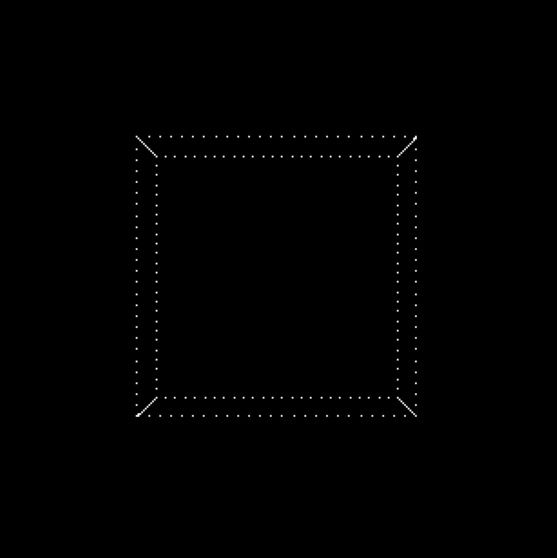

epsx =  0.06
epsy =  0.03
Lpixels =  300
Temps pour fair 360 degrès en 36 images :  44.23566913604736


In [75]:
from IPython.display import clear_output

def affichage(g,epsxx):
   global theta_c
   plt.ion()
   for i in range(36):
       
       theta_c += 10
       print(theta_c, '  degrès')
       Points_X_R0 = point_de_la_courbe_R0(g,Ix,Iy,Iz,epsxx)
       X = matrice(Points_X_R0)
       clear_output(wait=True)
       figure, ax = plt.subplots(figsize = (10,10), edgecolor = 'black', facecolor = 'black')
       plt.axis('off')
       plt.imshow(X, cmap = 'gray', vmin=0, vmax=1)
       plt.show()

t0 = time.time()
theta_c = 0

affichage(g_du_cube_dans_RC,epsx)

print('epsx = ', 0.06)
print('epsy = ', epsy)
print('Lpixels = ',L_pixels)
print("Temps pour fair 360 degrès en 36 images : ", time.time()-t0)

**Performance measurement of the programm**

Note that our program is testing condition arround the whole space with a step of epsilon wich means that **the theorical complexity of this program is O(1/epsilon^3) = O(n^3)**.

In [105]:
T = []
EPS = [eps for eps in [0.01*e_c, 0.015*e_c,0.020*e_c,0.025*e_c,0.030*e_c,0.035*e_c,0.04*e_c,0.045*e_c,0.05*e_c,0.055*e_c,0.06*e_c]]
for eps in EPS:
  t0 = time.time()
  for i in range(10): # On estime la mesure en faisant la moyenne sur 10 exécutions
    point_de_la_courbe_R0(g_du_cube_dans_RC,Ix,Iy,Iz,eps)
  T.append((time.time() - t0)/10)

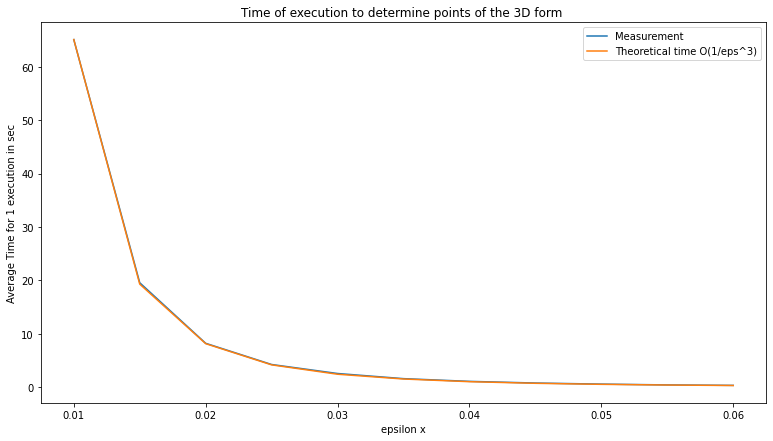

In [106]:
Theoretical_Time = [(T[0]*EPS[0]**3)/eps**3 for eps in EPS] #Pour parcourir l'espace la compléxitée augemente en O(1/eps^3)

fig, ax = plt.subplots(figsize = (13,7))
ax.plot(EPS, T, label = 'Measurement')
ax.plot(EPS, Theoretical_Time, label = 'Theoretical time O(1/eps^3)')

ax.legend()

ax.set(xlabel='epsilon x', ylabel='Average Time for 1 execution in sec',
       title='Time of execution to determine points of the 3D form ')
plt.show()

The programm speed is what we expected from the complexity theorical remarks

## 2) Optimisation avec Cython et comparaison des performances


Each test at each point can be done completely independently. Parallelization is therefore possible for these three for loops.

**Creation of the function point_of_curve_R0_Parallelise(g,I_x,I_y,I_z,eps_x) with Cython**

In [20]:
%reload_ext Cython

In [112]:
%%cython 

from cython.parallel import prange
#from libcpp cimport bool
from libc.math cimport fabs, sin, cos
cimport cython
import numpy as np


cdef:
  double A_cyth = 3 # taille de l'espace : x E [0,A] et z E [0,A]
  double B_cyth = 10 # taille de l'espace : y E [0,B]
  double y_cyth = 7 #distance entre la caméra et le centre du cube y_c E [B/2,B]
  double theta_cyth = 0 #angle de rotation de la courbe en degrès
  double e_cyth = 1 #epaisseur_cube
  double epsy_cyth = 0.04*e_cyth   

def set_theta_cyth(float value):
  global theta_cyth 
  theta_cyth = value

def get_theta_cyth():
  return theta_cyth

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing


def point_de_la_courbe_R0_cyth(list I_x , list I_y, list I_z, double eps_x):

    """Cette fonction retourne les point X (à eps_x près) de R0 tel que |g(X_RC)-Y)|<eps_y"""
    # le pas est le même dans les 3 dimensions eps_x   

    cdef :
      list Points_X_R0 = []
      int indice_tableau = 0
      int nx, ny, nz
      int cs = 1
      int n_threads = 4
      double x, y, z
      double xc, yc, zc   #x,y,z dans le repère RC
      double ax = I_x[0]
      double bx = I_x[1]

      double ay = I_y[0]
      double by = I_y[1]

      double az = I_z[0]
      double bz = I_z[1]
      int Cube = 0
      int NX = int((bx-ax)/eps_x)

    #for nx in prange( int((bx-ax)/eps_x), nogil = True, schedule='dynamic', num_threads = n_threads, chunksize=cs):
    for nx in prange(NX, nogil = True):
      x = ax + nx*eps_x
      for ny in range(int((by-ay)/eps_x)):
        y = ay + ny*eps_x
        for nz in range(int((by-ay)/eps_x)):
          z = az + nz*eps_x

          #On change en local, c'est à dire dans la boucle sans evoquer quelconque élément python

          xc = ((x-A_cyth/2)*sin(theta_cyth*3.14/180) - cos(theta_cyth*3.14/180)*(y-y_cyth))/e_cyth
          yc = ((x-A_cyth/2)*cos(theta_cyth*3.14/180) + sin(theta_cyth*3.14/180)*(y-y_cyth))/e_cyth
          zc = (z-A_cyth/2)/e_cyth

          # Testons si le point est dans le cube
          Cube = 0
          if fabs(fabs(xc)-e_cyth/2) < epsy_cyth and fabs(fabs(yc)-e_cyth/2) < epsy_cyth and fabs(zc) < e_cyth/2 + epsy_cyth:
            Cube = 1
          if Cube == 0 and fabs(fabs(zc)-e_cyth/2) < epsy_cyth and fabs(fabs(xc)-e_cyth/2) < epsy_cyth and fabs(yc) < e_cyth/2 + epsy_cyth:
            Cube = 1   
          if Cube == 0 and fabs(fabs(yc)-e_cyth/2) < epsy_cyth and fabs(fabs(zc)-e_cyth/2) < epsy_cyth and fabs(xc) < e_cyth/2 + epsy_cyth:
            Cube = 1
          
          if Cube == 1:
            #Le point est dans le cube
            with gil:
              #On réalise cette tache en séquitiel puisque la mojaorité de l'espace points ne respecte pas la condition Cube
              
              Points_X_R0.append(np.array([[x],[y],[z]]))

    return Points_X_R0


**Displaying the performance of the Cython program**

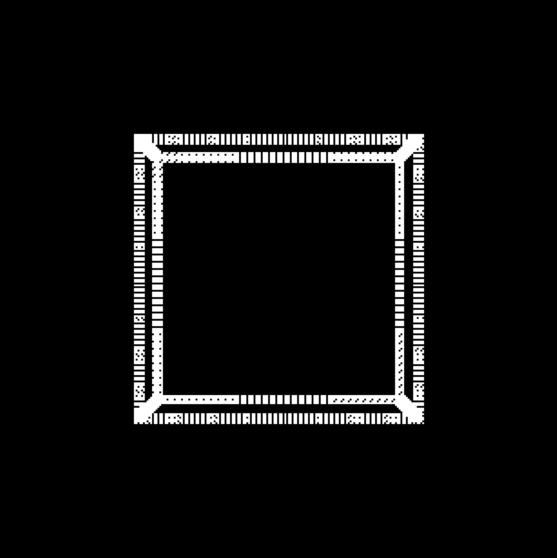

epsx =  0.01
epsy =  0.03
Lpixels =  300
Avec Cython : Temps pour fair 360 degrès en 36 images :  23.553518772125244


In [156]:
from IPython.display import clear_output

def affichage_cython():
   plt.ion()
   for i in range(36):
     time.sleep(0.01)
     set_theta_cyth(get_theta_cyth() + 10)
     print(get_theta_cyth(), '  degrès')
     Points_X_R0_cyth = point_de_la_courbe_R0_cyth(Ix, Iy, Iz, epsx)
     X_cyth = matrice(Points_X_R0_cyth)
     clear_output(wait=True)
     figure, ax = plt.subplots(figsize = (10,10), edgecolor = 'black', facecolor = 'black')
     plt.axis('off')
     plt.imshow(X_cyth, cmap = 'gray', vmin=0, vmax=1)
     plt.show()

t0 = time.time()

set_theta_cyth(0)

affichage_cython()

print('epsx = ', epsx)
print("Avec Cython : Temps pour faire 360 degrès en 36 images : ", time.time()-t0)

## Performance results Cython vs Pyhton

In [161]:
T_cyth = []
EPS_cyth = [eps for eps in [0.01*e_c, 0.015*e_c,0.020*e_c,0.025*e_c,0.030*e_c,0.035*e_c,0.04*e_c,0.045*e_c,0.05*e_c,0.055*e_c,0.06*e_c]]
for eps in EPS_cyth:
  t0 = time.time()
  for i in range(10): # On estime la mesure en faisant la moyenne sur 10 exécutions
    point_de_la_courbe_R0_cyth(Ix, Iy, Iz, eps)
  T_cyth.append((time.time() - t0)/10)

Theoretical_cyth = [(T_cyth[0]*EPS_cyth[0]**3)/eps**3 for eps in EPS_cyth]

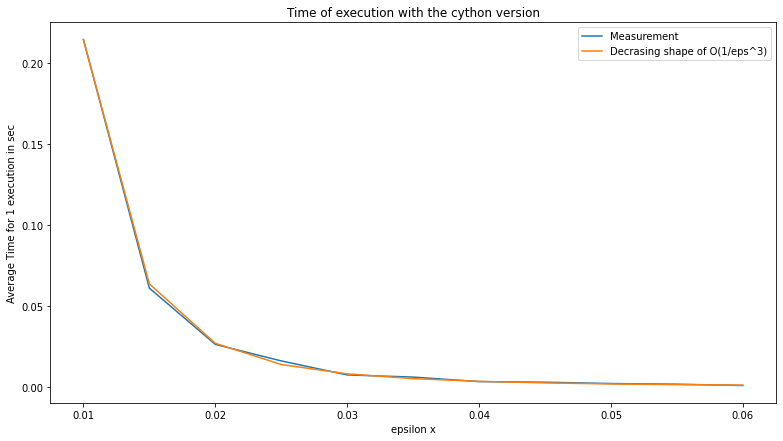

In [162]:
fig, ax = plt.subplots(figsize = (13,7))
ax.plot(EPS_cyth, T_cyth, label = 'Measurement')
ax.plot(EPS_cyth, Theoretical_cyth, label = 'Decrasing shape of O(1/eps^3)')

ax.legend()
ax.set(xlabel='epsilon x', ylabel='Average Time for 1 execution in sec',
       title='Time of execution with the cython version')
plt.show()

We see thats the performances are way better for the Cython programm but also that the shape of the deacreasing curve is still in O(1/eps^3). Which is logic because dispite the parallelization we are still working across the 3D space.

**Computation of the speed up according to the precision epsilon x**

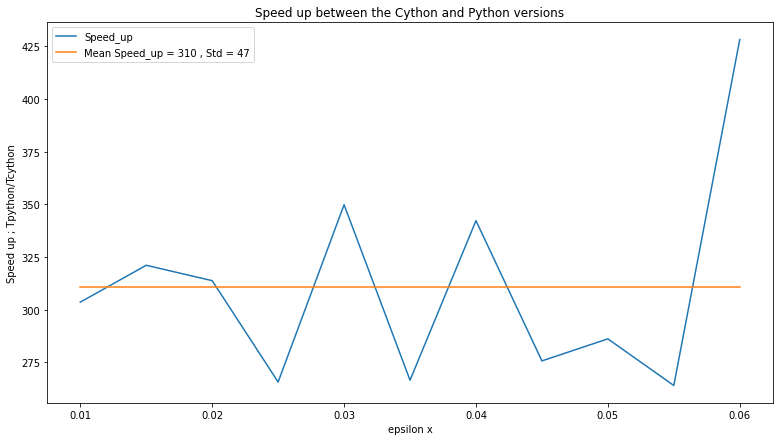

In [164]:
Speed_up = [T[i]/T_cyth[i] for i in range(len(T))]

speed_up_moyen = sum(Speed_up)/len(Speed_up)
Std = np.std(Speed_up)

fig, ax = plt.subplots(figsize = (13,7))
ax.plot(EPS_cyth, Speed_up, label = 'Speed_up')
ax.plot(EPS, [speed_up_moyen for i in range(len(T))], label = 'Mean Speed_up = ' + str(int(speed_up_moyen)) + " , Std = " + str(int(Std)))
ax.legend()

ax.set(xlabel='epsilon x', ylabel='Speed up ; Tpython/Tcython',
       title='Speed up between the Cython and Python versions')
plt.show()


**Visualsation of the speed up between the python and the cython versions**



To visualise how fast the cython version goes we can simulate side to side the two rotation fonctions. Despite the jerkiness due to python method to display, we clearly see the huge speed up thanks to cython. 



In [145]:
eps_visu = 0.015
Mat = []
for i in range(72):
  set_theta_cyth(get_theta_cyth() + 5)
  Points_X_R0_cyth = point_de_la_courbe_R0_cyth(Ix, Iy, Iz, eps_visu)
  Mat.append(matrice(Points_X_R0_cyth))


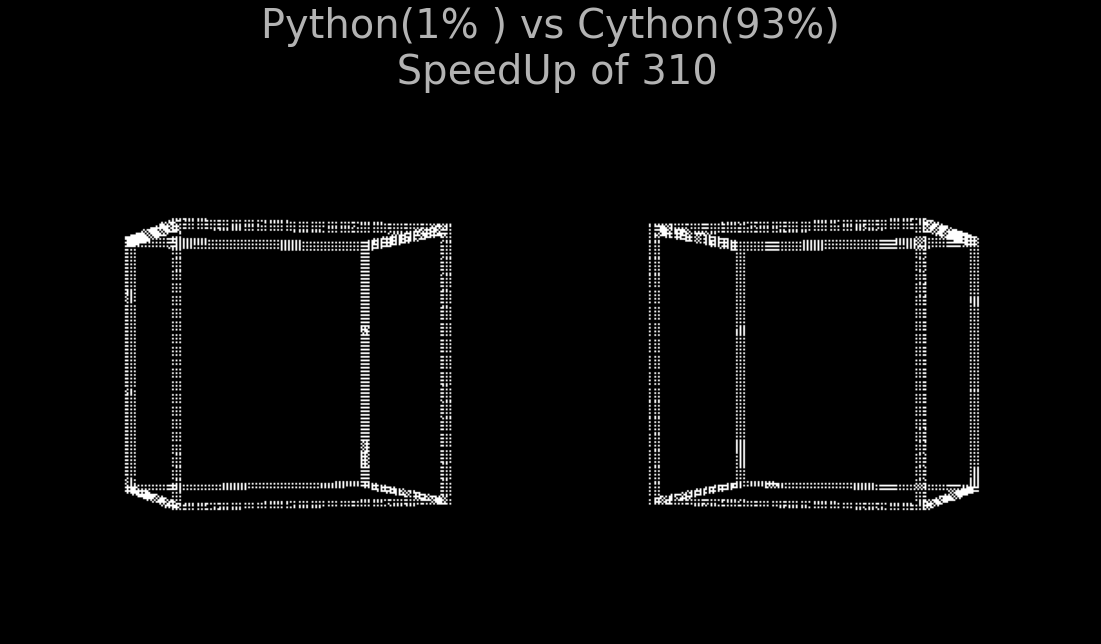

In [165]:
import ipywidgets as widgets
import time 

index_cython = 0
index_python = 0 
counter = 0
animation_time = 500
loop = 0
plt.ion()
while loop < animation_time:
  clear_output(wait=True)
  figure, ax = plt.subplots(figsize = (20,10), edgecolor = 'black', facecolor = 'black')
  plt.axis('off')
  ax.set_title('Python(' + str(int(index_python*100/72))+'% ) vs Cython(' + str(int(index_cython*100/72)) + '%)' + '\n SpeedUp of ' + str(int(speed_up_moyen)), color='0.7', fontsize = 40)
  Array = np.hstack((Mat[index_python],Mat[index_cython]))
  plt.imshow(Array, cmap = 'gray', vmin=0, vmax=1)
  plt.show()
  index_cython = (index_cython + 1)%72
  counter += 1
  loop +=1
  if counter == int(speed_up_moyen):
    index_python = (index_python + 1)%72
    counter = 0
  time.sleep(1/24)

  

With an epsilon of 0.01 and the right tools to display the results we could have a 2 frames by second animation of way prettier cube (results from the cython test) .

**REMARK : The Speed up can largely change with the machine.**

## Conclusion

This paper present how to display a 3D shape in python using a 2D matrix and how to make it rotate arround an axe and displayed it with the jupyter interfarce. In this example we displayed a empty cube but the python algorithm wokrs well for any shape smaller than the 3D space. Just rewriting the function g_du_cube_dans_RC is enough. (!! Carefull the current cython version does not use g_du_cube_dans_RC you should also redifine the conditions in the Cython function!).

Those algorithme requires hard computations when epsilon is small. With epsilon as the step in the 3D space to test conditions arround the whole 3D environnement. Thats why the computations complexity is in O(1/eps^3).

Thats why we build up a cython version of our algorithm which is using a C compiler. In the Cython world each variables types is not checked every time you use it, and you can parallelize computations inside the iterations parts.

**Results:**

  - Python version : Theorical complexity of O(n^3)
  - Python version : Measurment is matching the theoretical complexity
  - Cython version : Use of a parallel iterations (prange) without GIL
  - **Python vs Cython: Speed up of 310** (mean value) between the Python and Cython version (110 computatations with 11 differents epsilons)
  - Python vs Cython: The Speed up as standard error of 71 (11 samples)